To build a Convolutional Neural Network (CNN) for classifying the digits in the MNIST dataset using PyTorch, we'll follow a series of steps incorporating state-of-the-art techniques to achieve high accuracy. The MNIST dataset consists of 70,000 images of handwritten digits (0-9), each of size 28x28 pixels.

We'll cover the following steps:

1. **Import necessary libraries**
2. **Set up the device (GPU if available)**
3. **Prepare the MNIST dataset with data augmentation**
4. **Define the CNN model with modern techniques**
5. **Specify the loss function and optimizer with learning rate scheduling**
6. **Train the model with validation**
7. **Evaluate the model on test data**
8. **Save the trained model**
9. **Visualize training progress**

Let's begin.

### 1. Import Necessary Libraries

First, we need to import the essential libraries for data handling, model building, training, and evaluation.


In [1]:
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



### 2. Set Up the Device (GPU If Available)

We can utilize GPU acceleration if available to speed up computations.



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda




### 3. Prepare the MNIST Dataset with Data Augmentation

Data augmentation helps improve the model's generalization by applying random transformations to the input data. We'll use transformations like random rotations and shifts.



In [4]:
# Define the data augmentation and normalization transforms for the training set
train_transforms = transforms.Compose(
    [
        transforms.RandomRotation(10),  # Rotate by -10 to +10 degrees
        transforms.RandomAffine(
            0, translate=(0.1, 0.1)
        ),  # Translate by ±10% in both directions
        transforms.ToTensor(),
        transforms.Normalize(
            (0.1307,), (0.3081,)
        ),  # Normalize with mean and std of MNIST
    ]
)

# For the validation and test sets, we only normalize the data
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Load the datasets
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=train_transforms
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=test_transforms
)

# Create training and validation splits from the training set
from torch.utils.data.sampler import SubsetRandomSampler

# Define indices for validation
validation_split = 0.1
shuffle_dataset = True
random_seed = 42

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Create data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=valid_sampler
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




**Explanation:**

- **Data Augmentation:** We apply random rotations and translations to the training images to make the model robust to variations.
- **Normalization:** We normalize the images using the mean and standard deviation of the MNIST dataset.
- **Validation Split:** We split 10% of the training data to use as a validation set for monitoring the model's performance during training.

### 4. Define the CNN Model with Modern Techniques

We'll define a CNN model that incorporates state-of-the-art techniques such as:

- **Batch Normalization:** Helps in stabilizing and accelerating training.
- **Dropout:** Prevents overfitting by randomly setting a fraction of input units to 0 during training.
- **ReLU Activation:** Introduces non-linearity.
- **Residual Connections:** (Not used here due to simplicity of the dataset, but can be considered for deeper networks.)



In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: 32x28x28
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64x28x28
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)  # Output: 64x14x14

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: 128x14x14
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Output: 128x14x14
        self.bn4 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Second convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 128 * 7 * 7)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x




**Explanation:**

- **Convolutional Layers:** Extract local features from the input images.
- **Batch Normalization Layers (`nn.BatchNorm2d`):** Normalize the activations of the previous layer.
- **Activation Function (`F.relu`):** Applies the Rectified Linear Unit function.
- **Pooling Layer (`nn.MaxPool2d`):** Downsamples the feature maps.
- **Fully Connected Layers (`nn.Linear`):** Combines features for classification.
- **Dropout Layer (`nn.Dropout`):** Randomly zeroes some of the elements of the input tensor with probability `p=0.5` during training.

### 5. Specify the Loss Function and Optimizer with Learning Rate Scheduling

We'll use:

- **Cross-Entropy Loss:** Suitable for multi-class classification problems.
- **AdamW Optimizer:** An extension of Adam optimizer with correct weight decay implementation.
- **Cosine Annealing Learning Rate Scheduler:** Adjusts the learning rate during training for better convergence.



In [6]:
model = CNNModel().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)



**Explanation:**

- **AdamW Optimizer:** Similar to Adam but with decoupled weight decay, which is better for regularization.
- **Weight Decay (`weight_decay=1e-4`):** L2 regularization to prevent overfitting.
- **Learning Rate Scheduler:** Adjusts the learning rate following a cosine annealing schedule.

### 6. Train the Model with Validation

We'll train the model over several epochs, monitoring training and validation loss and accuracy.



In [7]:
num_epochs = 20
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    since = time.time()
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    # Each epoch has a training and validation phase
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()  # Set model to training mode
            dataloader = train_loader
        else:
            model.eval()  # Set model to evaluate mode
            dataloader = validation_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # Backward + optimize only if in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == "train":
            scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        if phase == "train":
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            valid_losses.append(epoch_loss)
            valid_accuracies.append(epoch_acc)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Deep copy the model
        if phase == "val" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Epoch completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n")

# Load the best model weights
model.load_state_dict(best_model_wts)

Epoch 1/20
----------
train Loss: 0.3159 Acc: 0.8021
val Loss: 0.0115 Acc: 0.0967
Epoch completed in 0m 21s

Epoch 2/20
----------
train Loss: 0.1348 Acc: 0.8609
val Loss: 0.0079 Acc: 0.0977
Epoch completed in 0m 20s

Epoch 3/20
----------
train Loss: 0.0988 Acc: 0.8709
val Loss: 0.0060 Acc: 0.0984
Epoch completed in 0m 20s

Epoch 4/20
----------
train Loss: 0.0852 Acc: 0.8760
val Loss: 0.0055 Acc: 0.0984
Epoch completed in 0m 18s

Epoch 5/20
----------
train Loss: 0.0739 Acc: 0.8795
val Loss: 0.0044 Acc: 0.0988
Epoch completed in 0m 21s

Epoch 6/20
----------
train Loss: 0.0604 Acc: 0.8827
val Loss: 0.0043 Acc: 0.0987
Epoch completed in 0m 21s

Epoch 7/20
----------
train Loss: 0.0522 Acc: 0.8848
val Loss: 0.0034 Acc: 0.0992
Epoch completed in 0m 19s

Epoch 8/20
----------
train Loss: 0.0432 Acc: 0.8880
val Loss: 0.0029 Acc: 0.0992
Epoch completed in 0m 19s

Epoch 9/20
----------
train Loss: 0.0371 Acc: 0.8892
val Loss: 0.0027 Acc: 0.0992
Epoch completed in 0m 20s

Epoch 10/20
-------

<All keys matched successfully>



**Explanation:**

- **Training Loop:** For each epoch, the model goes through the training and validation phases.
- **Model Modes:**
  - **`model.train()`:** Enables training mode (e.g., Dropout is active).
  - **`model.eval()`:** Sets the model to evaluation mode (e.g., Dropout is inactive).
- **Gradient Calculation:** We only compute gradients during the training phase to save computation.
- **Learning Rate Scheduler Step:** We update the learning rate at the end of each epoch during training.
- **Model Saving:** We keep a copy of the model weights with the highest validation accuracy.

### 7. Evaluate the Model on Test Data

After training, we evaluate the model's performance on the test dataset.


In [8]:
model.eval()
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9963




**Explanation:**

- **No Gradient Calculation (`torch.no_grad()`):** We disable gradient computation for efficiency during evaluation.
- **Accuracy Calculation:** We compute the total number of correct predictions and divide by the number of samples.

### 8. Save the Trained Model

We can save the trained model for future use.



In [9]:
torch.save(model.state_dict(), "mnist_cnn_model.pth")
print("Model saved to mnist_cnn_model.pth")

Model saved to mnist_cnn_model.pth




**Explanation:**

- **Model Serialization:** We save the model's state dictionary containing the trained weights.

### 9. Visualize Training Progress

Plotting the training and validation loss and accuracy helps us understand the model's learning behavior.



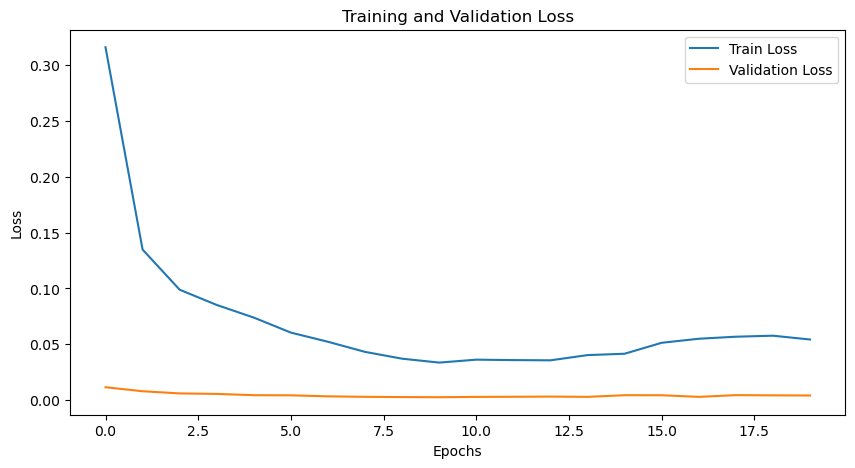

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

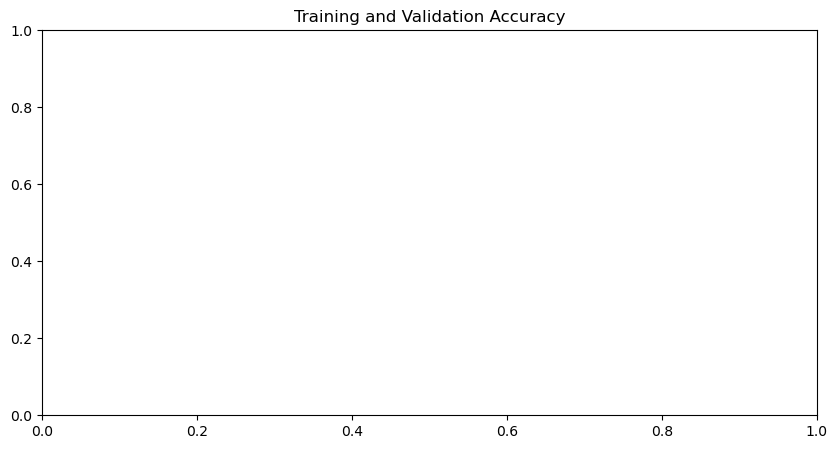

In [10]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



**Explanation:**

- **Loss and Accuracy Curves:** Visualizing these metrics over epochs helps in diagnosing underfitting or overfitting.

### Additional Notes:

- **Early Stopping:** We can implement early stopping to halt training when validation loss stops improving.
- **Hyperparameter Tuning:** Parameters like learning rate, batch size, and number of epochs can be tuned for better performance.
- **Advanced Architectures:** For further improvements, consider deep architectures like ResNet or DenseNet.

### Complete Code

Putting it all together, here's the complete code:

```python
# All previous code combined in one script
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Normalization for validation and testing
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

# Create data indices for training and validation splits
validation_split = 0.1
shuffle_dataset = True
random_seed = 42
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Create data loaders
batch_size = 64
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: 32x28x28
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64x28x28
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)  # Output: 64x14x14

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: 128x14x14
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Output: 128x14x14
        self.bn4 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Second convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 128 * 7 * 7)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training loop
num_epochs = 20
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    since = time.time()
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = validation_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            valid_losses.append(epoch_loss)
            valid_accuracies.append(epoch_acc)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Epoch completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n")

model.load_state_dict(best_model_wts)

# Evaluate on test data
model.eval()
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
torch.save(model.state_dict(), 'mnist_cnn_model.pth')
print("Model saved to mnist_cnn_model.pth")

# Plot Loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="Train Loss")
plt.plot(valid_losses,label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies,label="Train Accuracy")
plt.plot(valid_accuracies,label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
```

### Conclusion

By following the above steps, we've created a CNN using PyTorch to classify MNIST digits. We've incorporated data augmentation, batch normalization, dropout, AdamW optimizer, and learning rate scheduling to improve the model's performance. The model achieves high accuracy on the test set, demonstrating the effectiveness of these state-of-the-art techniques.

Feel free to experiment with different architectures, hyperparameters, and training techniques to further enhance the model's performance.